In [25]:
# setup
%matplotlib notebook
# set this to your working directory

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=1000,
                        stop_words='english',
                        ngram_range=(1,3))
X = vectorizer.fit_transform(df['opinion_text'])
pd.to_pickle(X,'X.pkl')
vocab = vectorizer.get_feature_names()
pd.to_pickle(vocab,'vocab.pkl')
Y = df['x_republican']

In [4]:
# Getting started with Keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential() # create a sequential model
model.add(Dense(50, # output neurons in layer       
          input_dim=X.shape[1], # number of inputs
          activation='relu')) # activation function
model.add(Dense(50, activation='relu')) # hidden layer
model.add(Dense(1, activation='sigmoid')) # output layer
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 50)                50050     
_________________________________________________________________
dense_5 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 52,651
Trainable params: 52,651
Non-trainable params: 0
_________________________________________________________________


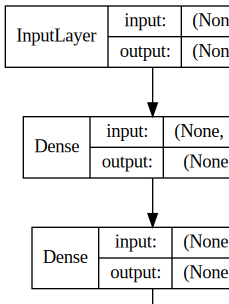

In [5]:
# Visualize a model

# Requires graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
dot = model_to_dot(model,
                   show_shapes=True,
                   show_layer_names=False)
SVG(dot.create(prog='dot', format='svg'))

In [7]:
# fit the model
model.compile(loss='binary_crossentropy', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=['accuracy']) # compute accuracy, for scoring

model_info = model.fit(X, Y, 
                      epochs=5,
                      validation_split=.2)

Train on 614 samples, validate on 154 samples
Epoch 1/5
614/614 [==============================] - 0s 248us/step - loss: 0.0773 - accuracy: 0.9805 - val_loss: 0.6876 - val_accuracy: 0.7532
Epoch 2/5
614/614 [==============================] - 0s 74us/step - loss: 0.0259 - accuracy: 1.0000 - val_loss: 0.7246 - val_accuracy: 0.7727
Epoch 3/5
614/614 [==============================] - 0s 82us/step - loss: 0.0094 - accuracy: 1.0000 - val_loss: 0.7066 - val_accuracy: 0.7792
Epoch 4/5
614/614 [==============================] - 0s 80us/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.7280 - val_accuracy: 0.7727
Epoch 5/5
614/614 [==============================] - 0s 78us/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.7667 - val_accuracy: 0.7857


In [8]:
# these are the learned coefficients
model.get_weights()

[array([[-0.0703392 , -0.05704933,  0.03671226, ..., -0.01868905,
          0.04439207,  0.0216919 ],
        [-0.01640469,  0.01873372,  0.04425856, ..., -0.06178307,
         -0.00294339, -0.04313529],
        [-0.04126189, -0.05354499, -0.04298904, ...,  0.01897706,
         -0.0311119 ,  0.01696494],
        ...,
        [-0.04792125, -0.03224736, -0.0471426 , ...,  0.06050275,
          0.02859242,  0.03824899],
        [-0.04930123,  0.03465421,  0.00097123, ...,  0.02963943,
         -0.06965665,  0.03842986],
        [-0.01624778, -0.03141611, -0.0360146 , ..., -0.03491909,
         -0.02315592,  0.00923658]], dtype=float32),
 array([ 0.01444617,  0.01498187, -0.01251119,  0.01141606, -0.01044505,
        -0.003732  ,  0.0170406 , -0.00260607,  0.00646558,  0.00531943,
        -0.01404952, -0.00207371,  0.01171512, -0.00881809,  0.00101333,
         0.02066946,  0.02019211,  0.01083846, -0.00522225,  0.02042156,
        -0.00127232, -0.00091598,  0.01872948, -0.0021769 ,  0.004

<IPython.core.display.Javascript object>


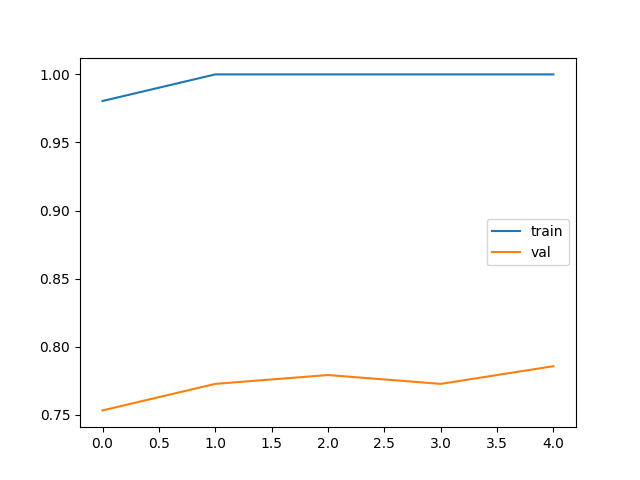

In [9]:
# Plot performance by epoch
plt.plot(model_info.epoch,model_info.history['accuracy'])
plt.plot(model_info.epoch,model_info.history['val_accuracy'])
plt.legend(['train', 'val'], loc='best')

In [10]:
# form probability distribution over classes
Ypred_prob = model.predict(X)
Ypred = Ypred_prob > .5

In [11]:
# Save a model
model.save('keras-clf.pkl')

In [12]:
# load model
from keras.models import load_model
model = load_model('keras-clf.pkl')

In [13]:
# Regression model with R-squared
Yreg = df['log_cite_count']
model = Sequential() # create a sequential model
model.add(Dense(50, # output neurons in layer       
          input_dim=X.shape[1], # number of inputs
          activation='relu')) # activation function
model.add(Dense(50, activation='relu')) # hidden layer
model.add(Dense(1)) # output layer

from keras import backend as K
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

model.compile(loss='mean_squared_error', # cost function
              optimizer='adam', # use adam as the optimizer
              metrics=[r2]) # compute r-squared
model_info = model.fit(X, Yreg, 
                      epochs=3)

from sklearn.metrics import r2_score
Ypred = model.predict(X)
r2_score(Yreg,Ypred)

Epoch 1/3
768/768 [==============================] - 0s 164us/step - loss: 27.7561 - r2: -13.4013
Epoch 2/3
768/768 [==============================] - 0s 58us/step - loss: 8.5295 - r2: -3.3102
Epoch 3/3
768/768 [==============================] - 0s 57us/step - loss: 5.2073 - r2: -1.5327


-0.7145108549825467

In [14]:
# Set up a basic model again for advanced features.
from keras.models import Sequential
from keras.layers import Activation, Dense
model = Sequential()
model.add(Dense(64, input_dim=1000, activation='relu')) 

In [15]:
# initializers
model.add(Dense(64, kernel_initializer='he_normal'))
model.add(Dense(64, kernel_initializer='he_uniform'))

In [16]:
# other activation functions (https://keras.io/activations/)
model.add(Dense(64, activation="elu"))

In [17]:
# batch normalization
from keras.layers.normalization import BatchNormalization
model.add(Dense(64, use_bias=False)) 
model.add(BatchNormalization())
model.add(Activation('relu'))

In [18]:
# regularization
from keras.regularizers import l1, l2, l1_l2
model.add(Dense(64, 
                kernel_regularizer=l2(0.01),
                activity_regularizer=l1(0.01)))
model.add(Dense(64, 
                kernel_regularizer=l1_l2(l1=0.01,l2=.01),
                activity_regularizer=l1_l2(l1=0.01,l2=.01)))

In [19]:
# Dropout
from keras.layers import Dropout
model.add(Dropout(0.5))

In [20]:
model.add(Dense(1,activation='sigmoid'))

In [21]:
# Optimizers
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
# Early stopping
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_acc', 
                          min_delta=0.0001, 
                          patience=5, 
                          mode='auto')
model.fit(X, Y, batch_size=128, 
           epochs=100, 
           callbacks=[earlystop], 
           validation_split=0.2)

Train on 614 samples, validate on 154 samples
Epoch 1/100
614/614 [==============================] - 0s 513us/step - loss: 77.0888 - accuracy: 0.4902 - val_loss: 562.9335 - val_accuracy: 0.7532
Epoch 2/100
614/614 [==============================] - 0s 42us/step - loss: 30.4436 - accuracy: 0.5391 - val_loss: 82.4546 - val_accuracy: 0.2468
Epoch 3/100
614/614 [==============================] - 0s 41us/step - loss: 23.4623 - accuracy: 0.6107 - val_loss: 66.6364 - val_accuracy: 0.7662
Epoch 4/100
614/614 [==============================] - 0s 47us/step - loss: 19.5541 - accuracy: 0.6466 - val_loss: 26.6502 - val_accuracy: 0.3312
Epoch 5/100
614/614 [==============================] - 0s 45us/step - loss: 16.4458 - accuracy: 0.6824 - val_loss: 25.3916 - val_accuracy: 0.7662
Epoch 6/100
614/614 [==============================] - 0s 47us/step - loss: 17.1666 - accuracy: 0.6938 - val_loss: 12.7433 - val_accuracy: 0.7662
Epoch 7/100
614/614 [==============================] - 0s 48us/step - loss: 

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


614/614 [==============================] - 0s 49us/step - loss: 15.1087 - accuracy: 0.7134 - val_loss: 12.1460 - val_accuracy: 0.7662
Epoch 9/100
614/614 [==============================] - 0s 47us/step - loss: 11.3743 - accuracy: 0.7410 - val_loss: 8.4361 - val_accuracy: 0.7662
Epoch 10/100
614/614 [==============================] - 0s 45us/step - loss: 10.8239 - accuracy: 0.7557 - val_loss: 10.3077 - val_accuracy: 0.7662
Epoch 11/100
614/614 [==============================] - 0s 47us/step - loss: 10.8921 - accuracy: 0.7557 - val_loss: 8.3772 - val_accuracy: 0.7662
Epoch 12/100
614/614 [==============================] - 0s 46us/step - loss: 9.9321 - accuracy: 0.7638 - val_loss: 7.8696 - val_accuracy: 0.7662
Epoch 13/100
614/614 [==============================] - 0s 47us/step - loss: 9.6355 - accuracy: 0.7687 - val_loss: 8.0348 - val_accuracy: 0.7662
Epoch 14/100
614/614 [==============================] - 0s 48us/step - loss: 9.6116 - accuracy: 0.7736 - val_loss: 7.6068 - val_accuracy: 

614/614 [==============================] - 0s 42us/step - loss: 5.3156 - accuracy: 0.7752 - val_loss: 5.3136 - val_accuracy: 0.7662
Epoch 65/100
614/614 [==============================] - 0s 44us/step - loss: 5.6893 - accuracy: 0.7752 - val_loss: 4.3548 - val_accuracy: 0.7662
Epoch 66/100
614/614 [==============================] - 0s 49us/step - loss: 5.4741 - accuracy: 0.7752 - val_loss: 5.0100 - val_accuracy: 0.7662
Epoch 67/100
614/614 [==============================] - 0s 46us/step - loss: 5.5576 - accuracy: 0.7752 - val_loss: 4.2834 - val_accuracy: 0.7662
Epoch 68/100
614/614 [==============================] - 0s 42us/step - loss: 5.4086 - accuracy: 0.7752 - val_loss: 4.7658 - val_accuracy: 0.7662
Epoch 69/100
614/614 [==============================] - 0s 44us/step - loss: 5.3751 - accuracy: 0.7752 - val_loss: 4.2395 - val_accuracy: 0.7662
Epoch 70/100
614/614 [==============================] - 0s 47us/step - loss: 5.1694 - accuracy: 0.7752 - val_loss: 4.7229 - val_accuracy: 0.766

In [23]:
# Batch Training with Large Data
from numpy import memmap
X_mm = memmap('X.pkl',shape=(768, 1000))

model.fit(X_mm, Y, batch_size=128, 
           epochs=3, 
           validation_split=0.2)

Train on 614 samples, validate on 154 samples
Epoch 1/3
614/614 [==============================] - 0s 35us/step - loss: 5.9441 - accuracy: 0.7752 - val_loss: 13.8657 - val_accuracy: 0.7662
Epoch 2/3
614/614 [==============================] - 0s 35us/step - loss: 6.3067 - accuracy: 0.7752 - val_loss: 15.2751 - val_accuracy: 0.7662
Epoch 3/3
614/614 [==============================] - 0s 43us/step - loss: 6.0481 - accuracy: 0.7752 - val_loss: 10.9808 - val_accuracy: 0.7662


In [24]:
# Grid search with KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# instantiate KerasClassifier with build function
def create_model(hidden_layers=1):  
    model = Sequential()
    model.add(Dense(16, input_dim=1000, 
                    activation='relu')) 
    for i in range(hidden_layers):
        model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics= ['accuracy'])
    return model
clf = KerasClassifier(create_model)

# set of grid search CV to select number of hidden layers
params = {'hidden_layers' : [0,1,2,3]}
grid = GridSearchCV(clf, param_grid=params)
grid.fit(X,Y)
grid.best_params_

Epoch 1/1
154/154 [==============================] - 0s 322us/step
Epoch 1/1
154/154 [==============================] - 0s 344us/step
Epoch 1/1
154/154 [==============================] - 0s 404us/step
Epoch 1/1
153/153 [==============================] - 0s 407us/step
Epoch 1/1
153/153 [==============================] - 0s 443us/step
Epoch 1/1
154/154 [==============================] - 0s 476us/step
Epoch 1/1
154/154 [==============================] - 0s 499us/step
Epoch 1/1
154/154 [==============================] - 0s 543us/step
Epoch 1/1
153/153 [==============================] - 0s 601us/step
Epoch 1/1
153/153 [==============================] - 0s 664us/step
Epoch 1/1
154/154 [==============================] - 0s 686us/step
Epoch 1/1
154/154 [==============================] - 0s 737us/step
Epoch 1/1
154/154 [==============================] - 0s 808us/step
Epoch 1/1
153/153 [==============================] - 0s 839us/step
Epoch 1/1
153/153 [==============================] - 0s 849us/

{'hidden_layers': 2}